<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Deep_Neural_Network_with_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

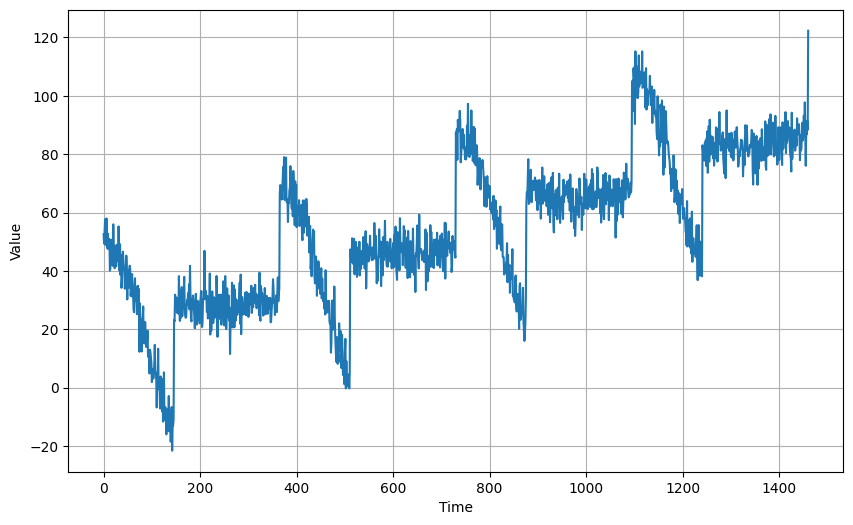

In [3]:
# Generate the Synthetic data
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [4]:
# Split the dataset
split_time = 1000

# Get the train data
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = time[split_time:]

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1,shift = 1,drop_remainder = True)

  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))

  dataset = dataset.map(lambda window : (window[:-1],window[-1]))

  dataset = dataset.shuffle(shuffle_buffer)

  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [8]:
# Generate the dataset window
dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [9]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_shape = [window_size],activation = 'relu'),
    tf.keras.layers.Dense(10,activation = 'relu'),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Train the model
model_baseline.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 1e-6,
        momentum = 0.9
    )
)

In [12]:
model_baseline.fit(
    dataset,
    epochs = 100
)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 849.5925
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 101.4458
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 71.3214
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 68.8232
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 65.8957
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 64.4562
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 63.1749
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 62.2341
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 61.9350
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 62.0524
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 60.6112
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 60.2664
Epoch 13/100
31/31 [===

1/1 [==============================] - 0s 49ms/step


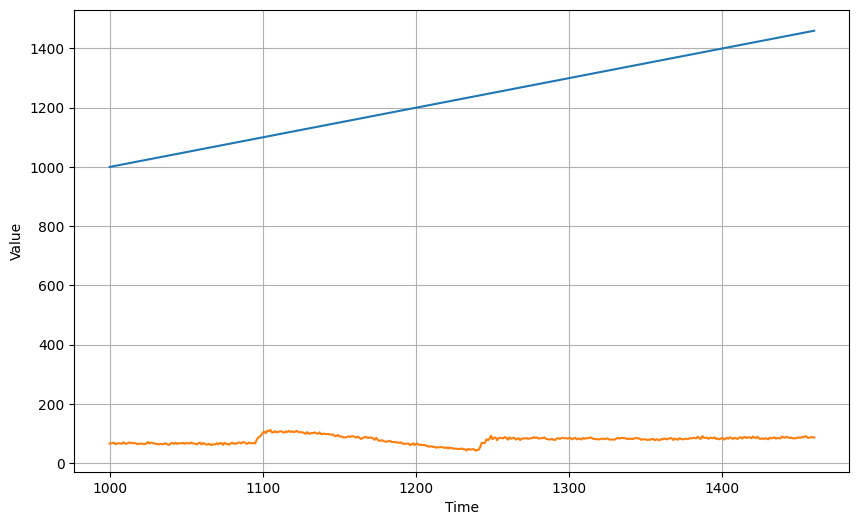

In [13]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size : ]

for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time : time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [14]:
# Compute the results
print(tf.keras.metrics.mean_squared_error(x_valid,results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid,results).numpy())

1343388.1
1151.719


# Tune the learning rate

In [15]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [16]:
# Set the learning_rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch / 20)
)

In [17]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model_tune.compile(
    loss = 'mse',
    optimizer = optimizer
)

In [19]:
# Train the model
history = model_tune.fit(
    dataset,
    epochs = 100,
    callbacks = [lr_schedule]
)

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 399.7401 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 172.7155 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 147.2684 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 146.5710 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 145.9434 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 145.2487 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 144.6311 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 143.7623 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 142.9787 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 142.6052 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 300.0)

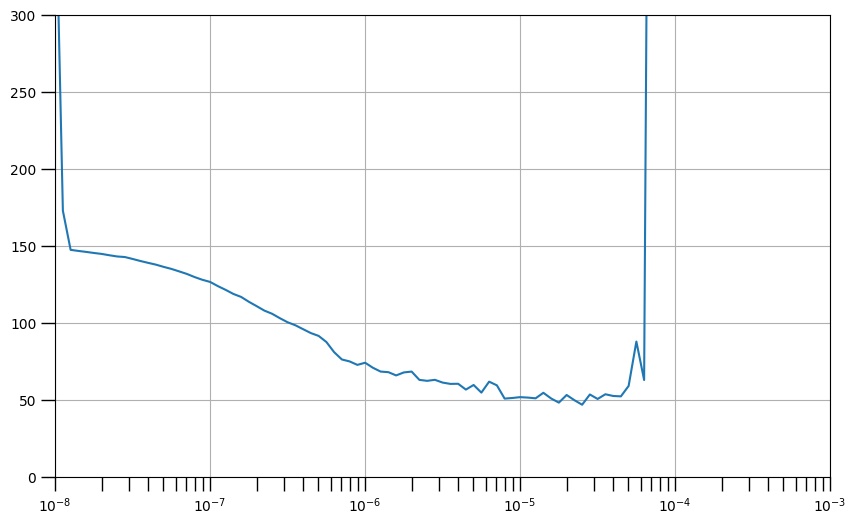

In [25]:
# define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100)/20))

# Set the figure size
plt.figure(figsize = (10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs,history.history['loss'])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [26]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [27]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

In [28]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 582.3624
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 98.9723
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 76.1659
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 72.3077
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 70.1995
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 68.6055
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 67.1699
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 64.8376
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 62.9678
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 63.0293
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 62.6420
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 61.8583
Epoch 13/100
31/31 [====

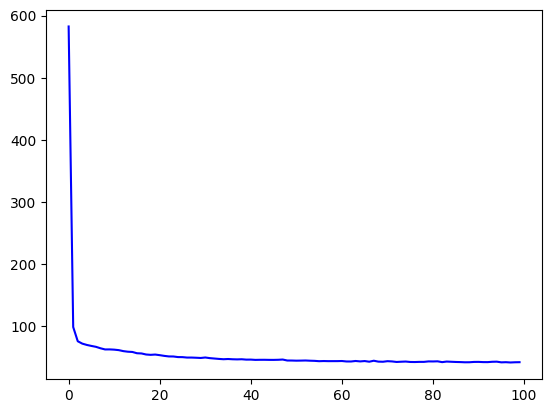

In [29]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

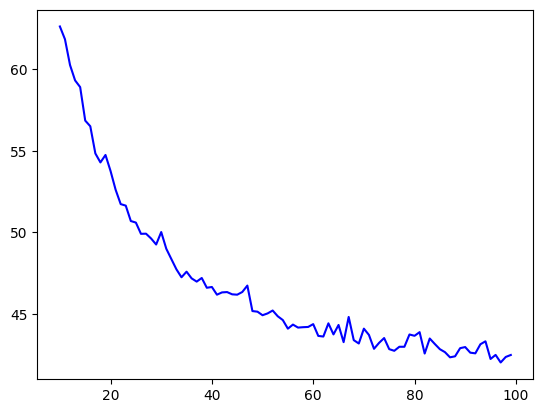

In [30]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()